In [1]:
! pip install transformers
! pip install keras_tuner

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
!echo $CUDA_VISIBLE_DEVICES

1


In [4]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Dropout, Conv1D, MaxPooling1D, Flatten, concatenate, BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import GridSearch
from keras_tuner import HyperModel, Objective
from keras import regularizers
from decimal import Decimal
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs available: ", gpus)

GPUs available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
if gpus:
    # Assuming you want to use the first GPU if available
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU: ", gpus[0])
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Using GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Memory growth enabled


In [8]:
import keras
SEED = 42
tf.random.set_seed(SEED)

In [9]:
choice = 'umberto' #umberto
max_length = 500
if choice == 'alberto':
    training_data = pd.read_csv('../Evalita2023/alberto_preprocessig_training/merged_alberto_preprocessing_training.csv')
    test_data = pd.read_csv('../Evalita2023/alberto_preprocessing_test/merged_alberto_preprocessing_test.csv')
    #max_length = 290
    print('alberto chosen')
else:
    training_data = pd.read_csv('../Evalita2023/umberto_preprocessig_training/merged_umberto_preprocessing_training.csv')
    test_data = pd.read_csv('../Evalita2023/umberto_preprocessing_test/merged_umberto_preprocessing_test.csv')
    #max_length = 357
    print('umberto chosen')

print(max_length)

umberto chosen
357


In [10]:
training_data

,anonymized_tweet_id,anonymized_text,label,dataset,retweet_count,favorite_count,anonymized_user_id,statuses_count,followers_count,friends_count,anonymized_description
0,217874450618134,[user] con tutte le denunce che si sta beccand...,1,training_politics,0.0,6.0,8.868893e+14,554.0,748.0,753.0,avete presente quegli stereotipi sui siciliani...
1,360042217507605,[hashtag] prescrizione [/hashtag] i t re magi ...,0,training_politics,154.0,448.0,2.570741e+14,35043.0,10838.0,4535.0,prof di latino e deputata pd ama lo sport la r...
2,817917484817935,il [hashtag] movimento cinque stelle [/hashtag...,1,training_politics,195.0,638.0,6.908473e+14,139750.0,7971.0,1866.0,medico appassionato di cinema d autore musica ...
3,145836038456701,che cosa cambia questa [hashtag] legge [/hasht...,0,training_politics,45.0,143.0,5.308388e+14,11234.0,10815.0,1810.0,veneto ! assessore regionale sviluppo economic...
4,740684329660693,in pochi giorni il [hashtag] ministro [/hashta...,0,training_politics,2.0,8.0,7.081260e+14,473.0,1171.0,1353.0,napoletano tifoso della fiorentina e rivoluzio...
...,...,...,...,...,...,...,...,...,...,...,...
4856,715670659156960,[hashtag] covid [/hashtag] [hashtag] draghi [/...,0,training_politics,2.0,2.0,3.198085e+14,8531.0,136.0,55.0,passione per l informazione la conoscenza ci p...
4857,512309888296620,cina [number] [number] [number] mila euro a ne...,0,training_politics,0.0,0.0,8.161793e+14,30137.0,3905.0,1085.0,la prima radio sino italiana canale [number] d...
4858,887061502405620,[user] [user] [user] anch io leggo i commenti ...,1,training_politics,1.0,2.0,8.840904e+14,2104.0,139.0,817.0,dr computers science nessuna politica per le f...
4859,531900858879345,trasporto pubblico simeone nominato consiglier...,0,training_politics,0.0,0.0,8.368163e+14,20623.0,399.0,14.0,la provinciaonline è un sito d informazione ch...


In [11]:
test_data

,anonymized_tweet_id,anonymized_text,label,dataset,retweet_count,favorite_count,anonymized_user_id,statuses_count,followers_count,friends_count,anonymized_description
0,424801448454884,questo anno [hashtag] babbo natale [/hashtag] ...,1,test_politics,486,1827,587049380396341,25758,132172,13522,rigore è quando arbitro fischia non vero bosko...
1,775194088981616,adesso che in mezzo alla strada grazie al verg...,1,test_politics,581,1996,924711002016921,27794,39224,4682,agisci in modo da trattare l umanità in te com...
2,386928936347190,circondatevi di persone che non sono diventate...,0,test_politics,47,252,62043137600220,18643,10758,8690,[url]
3,957546674360002,seriamente per capire se un ladro mi entra in ...,0,test_politics,7,30,801758473146114,132391,5621,2490,suora dal [number] [user] bloccami !
4,530526299555950,che poi è probabile che [hashtag] spataro [/ha...,0,test_politics,0,0,334768891377767,31009,423,306,icastico interista seguo la palla al cesto so ...
...,...,...,...,...,...,...,...,...,...,...,...
3698,195156040845120,come nasce un regime per il terzo reich il pro...,0,test_religious,0,0,775266801550239,20255,450,820,venezuela libre ! expect nothing prepare for e...
3699,137041976681572,[hashtag] il resto del carlino [/hashtag] la l...,0,test_religious,0,0,826968386244550,22604,373,305,dopo aver dato un consiglio concludo sempre co...
3700,391599381944152,[user] esatto brava ti dico di piu i nazisti n...,0,test_religious,0,0,157816101917459,10922,373,491,il covid e le guerre sono il braccio armato de...
3701,974317501584882,[user] togliere la parola non vaccinati e mett...,0,test_religious,0,0,194540947910741,721,31,169,galileo copernico giordano bruno furono consid...


In [12]:
test_religious_data = test_data.loc[test_data['dataset'] == 'test_religious']
test_politics_data = test_data.loc[test_data['dataset'] == 'test_politics']

In [13]:
test_politics_data

,anonymized_tweet_id,anonymized_text,label,dataset,retweet_count,favorite_count,anonymized_user_id,statuses_count,followers_count,friends_count,anonymized_description
0,424801448454884,questo anno [hashtag] babbo natale [/hashtag] ...,1,test_politics,486,1827,587049380396341,25758,132172,13522,rigore è quando arbitro fischia non vero bosko...
1,775194088981616,adesso che in mezzo alla strada grazie al verg...,1,test_politics,581,1996,924711002016921,27794,39224,4682,agisci in modo da trattare l umanità in te com...
2,386928936347190,circondatevi di persone che non sono diventate...,0,test_politics,47,252,62043137600220,18643,10758,8690,[url]
3,957546674360002,seriamente per capire se un ladro mi entra in ...,0,test_politics,7,30,801758473146114,132391,5621,2490,suora dal [number] [user] bloccami !
4,530526299555950,che poi è probabile che [hashtag] spataro [/ha...,0,test_politics,0,0,334768891377767,31009,423,306,icastico interista seguo la palla al cesto so ...
...,...,...,...,...,...,...,...,...,...,...,...
2718,740119007060498,[user] il problema non sono le dosi cazzaro [u...,1,test_politics,0,0,412574071640870,4008,319,289,nel tempo del inganno universale dire la verit...
2719,92974117033041,[user] reddito di cittadinanza fatto da un gov...,1,test_politics,0,0,504744452374305,493,4,138,pensatore / filosofo meridionale
2721,791719192220932,[user] sono assuefatti non se ne rendono nemme...,1,test_politics,0,3,702503684856325,11035,716,699,bloccato da salvini antifa nel dna rocker per ...
2798,25360395404144,[hashtag] sondaggio polito co [/hashtag] [hash...,0,test_politics,0,0,546741055894686,156,117,394,consulenza strategica integrata comunicazione ...


In [14]:
# Load model directly
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("idb-ita/gilberto-uncased-from-camembert")  #m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0 #Musixmatch/umberto-commoncrawl-cased-v1

def tokenize_function(sentence1, sentence2):
    tokens = tokenizer.encode_plus(sentence1, sentence2, max_length=max_length,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [15]:
from sklearn.model_selection import train_test_split

labels = training_data['label']

X_train, X_val, y_train, y_val = train_test_split(training_data, labels, test_size=0.20, random_state=SEED, stratify=labels)

In [16]:
X_train.head()

,anonymized_tweet_id,anonymized_text,label,dataset,retweet_count,favorite_count,anonymized_user_id,statuses_count,followers_count,friends_count,anonymized_description
2419,820323163384842,non prendetevela egregi gestori suddetti ma mi...,0,training_politics,0.0,0.0,9.366533e+14,4804.0,357.0,677.0,scrivo libri faccio radio mi occupo di promozi...
3279,498172779077527,[user] [user] [user] [user] mi dissocio a part...,1,training_politics,0.0,0.0,2.302434e+14,11427.0,128.0,523.0,[hashtag] elezioni subito [/hashtag] in pensio...
3497,959416139898966,[user] questo è da prenderlo a calci nel culo ...,1,training_politics,0.0,3.0,6.167306e+13,7905.0,102.0,836.0,vado a comprare le sigarette ma se non fumi ? ...
2190,367618236249208,dopo [number] di [hashtag] cassa integrazione ...,1,training_politics,0.0,0.0,6.027086e+14,297.0,3.0,9.0,molto più che che un cuore di panna
2838,148083376257936,[user] [user] che poi la carità di cui parla i...,0,training_politics,0.0,0.0,2.560303e+14,122627.0,2271.0,4994.0,salvo complicanze sempre


In [17]:
y_train.head()

2419    0
3279    1
3497    1
2190    1
2838    0
Name: label, dtype: int64

### Normalize dataset

In [18]:
# Initialize the scaler
scaler = StandardScaler()
columns_to_normalize = ['retweet_count', 'favorite_count', 'statuses_count', 'followers_count', 'friends_count']

# Fit the scaler on the training data and transform it
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])

# Transform the validation and test data with the same scaler
X_val[columns_to_normalize] = scaler.transform(X_val[columns_to_normalize])
test_religious_data[columns_to_normalize] = scaler.transform(test_religious_data[columns_to_normalize])
test_politics_data[columns_to_normalize] = scaler.transform(test_politics_data[columns_to_normalize])

X_train.head()

,anonymized_tweet_id,anonymized_text,label,dataset,retweet_count,favorite_count,anonymized_user_id,statuses_count,followers_count,friends_count,anonymized_description
2419,820323163384842,non prendetevela egregi gestori suddetti ma mi...,0,training_politics,-0.248056,-0.212369,9.366533e+14,-0.209420,-0.162088,-0.371403,scrivo libri faccio radio mi occupo di promozi...
3279,498172779077527,[user] [user] [user] [user] mi dissocio a part...,1,training_politics,-0.248056,-0.212369,2.302434e+14,-0.193195,-0.164952,-0.417355,[hashtag] elezioni subito [/hashtag] in pensio...
3497,959416139898966,[user] questo è da prenderlo a calci nel culo ...,1,training_politics,-0.248056,-0.203155,6.167306e+13,-0.201823,-0.165277,-0.323960,vado a comprare le sigarette ma se non fumi ? ...
2190,367618236249208,dopo [number] di [hashtag] cassa integrazione ...,1,training_politics,-0.248056,-0.212369,6.027086e+14,-0.220461,-0.166515,-0.570726,molto più che che un cuore di panna
2838,148083376257936,[user] [user] che poi la carità di cui parla i...,0,training_politics,-0.248056,-0.212369,2.560303e+14,0.079220,-0.138151,0.916735,salvo complicanze sempre


In [19]:
X_val.head()

,anonymized_tweet_id,anonymized_text,label,dataset,retweet_count,favorite_count,anonymized_user_id,statuses_count,followers_count,friends_count,anonymized_description
1390,17202875150669,è [hashtag] bullismo [/hashtag] anche la [hash...,0,training_politics,-0.248056,-0.209298,4.085561e+14,-0.218918,-0.165915,-0.502992,mama always said life was like a box of chocol...
4040,148908204400470,situazione attuale italia uno sta picconando i...,1,training_politics,-0.141249,-0.150938,6.844551e+14,-0.188751,-0.143291,-0.077492,comunista antipatica nata nel mondo la sola pa...
3808,328868193922911,amo l italia ma i suoi [hashtag] politici [/ha...,0,training_politics,-0.114547,0.331298,5.740365e+13,-0.216343,-0.110600,0.851985,su twitter perché non mi arrendo a un italia c...
774,862308711639804,la vera differenza tra coalizione [hashtag] mo...,0,training_politics,-0.248056,-0.212369,2.599462e+13,-0.203808,-0.164589,-0.516420,nosce te ipsum veritas vos liberat il mondo ec...
1062,448098502906783,fuori dalla maggioranza con un popolo di [hash...,0,training_politics,0.392787,0.233008,9.381988e+14,-0.200885,-0.074358,1.577364,autore di satira mi trovate su [user] [user] [...


### creating dataset

In [20]:
# initialize two arrays for input tensors
Xids = np.zeros((len(X_train['anonymized_text']), max_length))
Xmask = np.zeros((len(X_train['anonymized_text']), max_length))
Xmeta = X_train[['retweet_count', 'favorite_count', 'statuses_count', 'followers_count', 'friends_count']]

for i, (sentence1, sentence2) in enumerate(zip(X_train['anonymized_text'],X_train['anonymized_description'])):
    Xids[i, :], Xmask[i, :] = tokenize_function(sentence1, sentence2)

In [21]:
labels = y_train
BATCH_SIZE = 128  # we will use batches of 128

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, Xmeta, labels))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, metadata, labels):
    return {'input_ids': input_ids, 'attention_mask': masks, 'meta_input': metadata}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# batch data
dataset = dataset.batch(BATCH_SIZE)
train=dataset
del dataset

In [22]:
XidsVal = np.zeros((len(X_val['anonymized_text']), max_length))
XmaskVal = np.zeros((len(X_val['anonymized_text']), max_length))
XmetaVal = X_val[['retweet_count', 'favorite_count', 'statuses_count', 'followers_count', 'friends_count']]

for i, (sentence1, sentence2) in enumerate(zip(X_val['anonymized_text'], X_val['anonymized_description'])):
    XidsVal[i, :], XmaskVal[i, :] = tokenize_function(sentence1, sentence2)
labels_val = y_val

dataset = tf.data.Dataset.from_tensor_slices((XidsVal, XmaskVal, XmetaVal, labels_val))
dataset = dataset.map(map_func)
dataset = dataset.batch(BATCH_SIZE)
validation = dataset
del dataset

In [23]:
XidsTestPolitics = np.zeros((len(test_politics_data['anonymized_text']), max_length))
XmaskTestPolitics = np.zeros((len(test_politics_data['anonymized_text']), max_length))
XmetaTestPolitics = test_politics_data[['retweet_count', 'favorite_count', 'statuses_count', 'followers_count', 'friends_count']]

for i, (sentence1, sentence2) in enumerate(zip(test_politics_data['anonymized_text'],test_politics_data['anonymized_description'])):
    XidsTestPolitics[i, :], XmaskTestPolitics[i, :] = tokenize_function(sentence1, sentence2)

labelsTPolitics = test_politics_data['label']

dataset = tf.data.Dataset.from_tensor_slices((XidsTestPolitics, XmaskTestPolitics, XmetaTestPolitics,labelsTPolitics))
dataset = dataset.map(map_func)
dataset = dataset.batch(BATCH_SIZE)
test_politics = dataset

del dataset  # delete dataset to free up disk-space

In [24]:
XidsTestReligious = np.zeros((len(test_religious_data['anonymized_text']), max_length))
XmaskTestReligious = np.zeros((len(test_religious_data['anonymized_text']), max_length))
XmetaTestReligious = test_religious_data[['retweet_count', 'favorite_count', 'statuses_count', 'followers_count', 'friends_count']]

for i, (sentence1, sentence2) in enumerate(zip(test_religious_data['anonymized_text'],test_religious_data['anonymized_description'])):
    XidsTestReligious[i, :], XmaskTestReligious[i, :] = tokenize_function(sentence1, sentence2)

labelsTReligious = test_religious_data['label']

dataset = tf.data.Dataset.from_tensor_slices((XidsTestReligious, XmaskTestReligious, XmetaTestReligious ,labelsTReligious))
dataset = dataset.map(map_func)
dataset = dataset.batch(BATCH_SIZE)
test_religious = dataset

del dataset  # delete dataset to free up disk-space

### Model training/testing

In [25]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [26]:
from transformers import TFAutoModel

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = TFAutoModel.from_pretrained("idb-ita/gilberto-uncased-from-camembert", from_pt=True) #m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0 #Musixmatch/umberto-commoncrawl-cased-v1

        input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
        mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
        meta_input = Input(shape=(Xmeta.shape[1],), name='meta_input', dtype='float32')

        # we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
        embeddings = model(input_ids, attention_mask=mask)[0]

        X = Bidirectional(LSTM(units=hp.Choice('LSTM_units', values=[64, 128]), return_sequences= True))(embeddings) 
        X = Conv1D(filters=hp.Choice('filters', values=[32, 128]), kernel_size=hp.Choice('kernel_size', values=[3,9]), activation="relu")(X)
        X = MaxPooling1D(2)(X)
        X = Dropout(rate=hp.Choice('rate_dropout', values=[0.6, 0.7]))(X)
        X = Flatten()(X)
        X = concatenate([X, meta_input])
        #X = BatchNormalization()(X)
        X = Dense(units=hp.Choice('dense_units', values=[16,32,64]), kernel_regularizer=regularizers.L2(hp.Choice('reg_value', values=[0.0,0.001])), activation="relu")(X)
        y = Dense(1, activation='sigmoid', name='outputs')(X)

        # define input and output layers of our model
        best_model = Model(inputs=[input_ids, mask, meta_input], outputs=y)

        # freeze the BERT layer - otherwise we will be training 100M+ parameters...
        best_model.layers[2].trainable = False

        best_model.compile(optimizer=Adam(learning_rate = hp.Choice('learning_rate', values=[0.01, 1e-3]), clipnorm = 3), loss="binary_crossentropy", metrics=[F1Score()])
        return best_model

In [27]:
tuner = GridSearch(
    hypermodel = MyHyperModel(),
    objective = Objective('val_loss', 'min'),
    max_trials = 15,
    seed = SEED,
    executions_per_trial = 1,
    overwrite = False,
    project_name="GilBerto_BiLSTM+CNN_contextual")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [28]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 7
LSTM_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 128], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 9], 'ordered': True}
rate_dropout (Choice)
{'default': 0.6, 'conditions': [], 'values': [0.6, 0.7], 'ordered': True}
dense_units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
reg_value (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.001], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [30]:
es = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True, verbose=1)
tuner.search(train, epochs=15, validation_data=validation, callbacks=[es])

In [31]:
# Random Search 10 best results
tuner.results_summary()

Results summary
Results in ./GilBerto_BiLSTM+CNN_contextual
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 13 summary
Hyperparameters:
LSTM_units: 64
filters: 32
kernel_size: 3
rate_dropout: 0.7
dense_units: 16
reg_value: 0.0
learning_rate: 0.001
Score: 0.36270371079444885

Trial 05 summary
Hyperparameters:
LSTM_units: 64
filters: 32
kernel_size: 3
rate_dropout: 0.6
dense_units: 32
reg_value: 0.0
learning_rate: 0.001
Score: 0.3636668920516968

Trial 01 summary
Hyperparameters:
LSTM_units: 64
filters: 32
kernel_size: 3
rate_dropout: 0.6
dense_units: 16
reg_value: 0.0
learning_rate: 0.001
Score: 0.37472057342529297

Trial 09 summary
Hyperparameters:
LSTM_units: 64
filters: 32
kernel_size: 3
rate_dropout: 0.6
dense_units: 64
reg_value: 0.0
learning_rate: 0.001
Score: 0.384641170501709

Trial 07 summary
Hyperparameters:
LSTM_units: 64
filters: 32
kernel_size: 3
rate_dropout: 0.6
dense_units: 32
reg_value: 0.001
learning_rate: 0.001
Score: 0.38495293259620667

Tri

In [32]:
# Focus on Best Trial
tuner.oracle.get_best_trials()[0].get_state()

{'trial_id': '13',
 'hyperparameters': {'space': [{'class_name': 'Choice',
    'config': {'name': 'LSTM_units',
     'default': 64,
     'conditions': [],
     'values': [64, 128],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'filters',
     'default': 32,
     'conditions': [],
     'values': [32, 128],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'kernel_size',
     'default': 3,
     'conditions': [],
     'values': [3, 9],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'rate_dropout',
     'default': 0.6,
     'conditions': [],
     'values': [0.6, 0.7],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'dense_units',
     'default': 16,
     'conditions': [],
     'values': [16, 32, 64],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'reg_value',
     'default': 0.0,
     'conditions': [],
     'values': [0.0, 0.001],
     'ordered': True}},


In [33]:
# Focus on Best Trial
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'LSTM_units': 64,
 'filters': 32,
 'kernel_size': 3,
 'rate_dropout': 0.7,
 'dense_units': 16,
 'reg_value': 0.0,
 'learning_rate': 0.001}

In [34]:
# Best Model
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 357)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 357)]        0                                            
__________________________________________________________________________________________________
tf_camembert_model_1 (TFCamembe TFBaseModelOutputWit 110621952   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 357, 128)     426496      tf_camembert_model_1[0][0] 

In [35]:
# Training of best model
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
history = best_model.fit(train, batch_size=BATCH_SIZE, epochs=60, callbacks=es, validation_data=validation)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/60


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


31/31 [==============================] - ETA: 0s - loss: 0.6605 - f1_score: 0.0751

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


31/31 [==============================] - 100s 3s/step - loss: 0.6605 - f1_score: 0.0751 - val_loss: 0.6416 - val_f1_score: 0.0000e+00
Epoch 2/60
31/31 [==============================] - 74s 2s/step - loss: 0.6396 - f1_score: 0.1213 - val_loss: 0.6230 - val_f1_score: 0.2206
Epoch 3/60
31/31 [==============================] - 74s 2s/step - loss: 0.6078 - f1_score: 0.3905 - val_loss: 0.5795 - val_f1_score: 0.5280
Epoch 4/60
31/31 [==============================] - 74s 2s/step - loss: 0.5859 - f1_score: 0.4734 - val_loss: 0.5495 - val_f1_score: 0.5866
Epoch 5/60
31/31 [==============================] - 74s 2s/step - loss: 0.5567 - f1_score: 0.5381 - val_loss: 0.5270 - val_f1_score: 0.6396
Epoch 6/60
31/31 [==============================] - 74s 2s/step - loss: 0.5342 - f1_score: 0.5822 - val_loss: 0.4873 - val_f1_score: 0.6677
Epoch 7/60
31/31 [==============================] - 74s 2s/step - loss: 0.5140 - f1_score: 0.5997 - val_loss: 0.4999 - val_f1_score: 0.6867
Epoch 8/60
31/31 [========

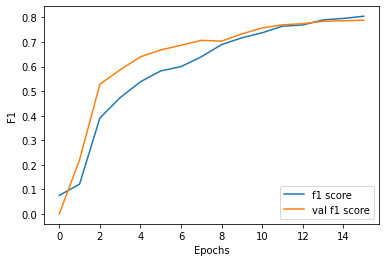

In [44]:
#F1-score plot
plt.plot(history.history["f1_score"][:16], label='f1 score')
plt.plot(history.history["val_f1_score"][:16], label='val f1 score')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.ylim()
#plt.xticks(np.arange(len(history.history["val_f1_score"])), np.arange(1, len(history.history["val_f1_score"])+1))
plt.legend(loc = 'lower right')

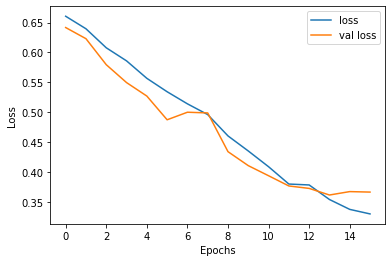

In [45]:
#Loss plot
plt.plot(history.history["loss"][:16], label='loss')
plt.plot(history.history["val_loss"][:16], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim()
#plt.xticks(np.arange(len(history.history["loss"])), np.arange(1, len(history.history["loss"])+1))
#plt.xticks(np.arange(len(history.history["val_loss"])), np.arange(1, len(history.history["val_loss"])+1))
plt.legend(loc = 'upper right')

In [38]:
pred_politics = best_model.predict(test_politics) > 0.5

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [39]:
# Getting the Classification Report
print(classification_report(list(labelsTPolitics), pred_politics, digits=4))

              precision    recall  f1-score   support

           0     0.7632    0.9528    0.8476       636
           1     0.9307    0.6819    0.7871       591

    accuracy                         0.8223      1227
   macro avg     0.8470    0.8174    0.8173      1227
weighted avg     0.8439    0.8223    0.8184      1227



In [40]:
pred_religious = best_model.predict(test_religious) > 0.5

In [41]:
# Getting the Classification Report
print(classification_report(list(labelsTReligious), pred_religious, digits=4))

              precision    recall  f1-score   support

           0     0.8519    0.8712    0.8614      2112
           1     0.1392    0.1209    0.1294       364

    accuracy                         0.7609      2476
   macro avg     0.4955    0.4960    0.4954      2476
weighted avg     0.7471    0.7609    0.7538      2476

